# Modelo: Boosting

El modelo a entrenar en el siguiente notebook será un ensamble. En particular buscaremos hacer un **Boosting**. Boosting es un ensamble de tipo homogéneo que consiste en entrenar diferentes instancias con un modelo de forma iterativa.

La particularidad de Boosting se da en como se realiza ese entrenamiento. En primer lugar, se entrena un modelo como lo veniamos haciendo hasta ahora. A continuación, a las instancias en las que el primer modelo falló se les asigna un peso mayor para realizar el entrenamiento del segundo modelo. Es decir, un indicativo para comunicarle al segundo modelo en que instancias se equivocó el primer modelo, las mal clasificadas. En definitiva Boosting, tendras distintos modelos donde cada uno proriza los mal clasificados del anterior modelo.

De esta manera se continua de forma iterativa hasta obtener un score deseado. El sesgo y la varianza baja mucho de esta forma, se contrapone el sesgo de cada modelo anterior en la cadena de iteración. Te fijarias mucho en ciertos datos y luego en otros iteración por iteración.

A la hora de evaluar instancias, el modelo realiza una votación ponderada (según que tan bien fue la performance de ese modelo durante el entrenamiento) entre todos sus estimadores y arroja una predicción.

Para implementar este ensamble utilizaremos **GradientBoostingClassifier** de la libreria sklearn. Esta implementación utiliza árboles de decisión como algoritmo base. Además, utiliza una función de perdida para calcular el error en las predicciones arrojadas por cada árbol y a partir de ella optimiza los parámetros de los siguientes árboles mediante descenso por gradiente.

## Librerias y funciones necesarias

Comenzamos importando las librerias y funciones que serán necesarias para preprocesar nuestros datos, realizar nuestro entrenamiento y obtener metricas 

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import tree


In [15]:
from preprocessing import obtener_datasets
from preprocessing import aplicar_preparacion
from preprocessing import conversion_numerica
from preprocessing import plot_roc_curves
from preprocessing import graficar_matriz_confusion
from preprocessing import aplicar_preparacion_generalizado
from preprocessing import conversion_numerica_generalizada
from preprocessing import get_dataframe_scaled
from preprocessing import reduccion_rfecv
from preprocessing import get_dataframe_polynomial

## Primer preprocesamiento

En primer lugar obtenemos el dataset para entrenar y el holdout. En segundo lugar, aplicamos una función que trabaja sobre las features, generalizando algunas y dejando de lado otras según lo observado en la primer parte de este trabajo práctico. También separamos a la variable target del resto del dataset. Por último, convertimos a númericas las variables categoricas para poder entrenar nuestro modelo

In [16]:
df, df_for_prediction = obtener_datasets()
X_df, y_df = aplicar_preparacion(df)
X_df = conversion_numerica(X_df) 

Aplicando 'conversion_numerica' en las variables categóricas.


Luego vamos a realizar un split del dataset para dividir en train y test. Como observamos en la primer parte de este trabajo práctico, la variable target no esta distribuida uniformente por lo cual realizamos una división estratificada

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=30,stratify=y_df)

### Entrenamiento

Vamos a realizar un entrenamiento con 5 folds. Para ello utilizaremos StratifiedKFold para asegurarnos de obtener folds balanceados. 

In [32]:
cv = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf = GradientBoostingClassifier(random_state=10)
params = {"max_depth":np.arange(3,8),
          "min_samples_leaf":np.arange(50,150,20),
          "n_estimators":np.arange(1,300,100)}
          #"learning_rate":np.arange(0.1,0.9,0.1)}
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1, verbose = True)


Ahora sí, entrenamos nuestro modelo

In [33]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 750 candidates, totalling 3750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 458 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 808 tasks      | elapsed: 14.7min


KeyboardInterrupt: 

Realizamos nuestras predicciones para una análisis más amplio

In [ ]:
y_pred = clf.predict(X_test)

### Metricas

In [ ]:
print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Accuracy sobre train: ", "%0.16f"  % accuracy_score(clf.predict(X_train), y_train))
print(classification_report(y_test, y_pred, target_names=["Bajo valor", "Alto valor"]))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train) # 9296

Obtenemos buenas métricas a nivel general y además la brecha entre el test y el train parece ser lógica por lo que entendemos no estariamos overfitteado (algo que al usar aŕboles lógicamente hay que cuidar). Probemos igualmente otro preprocesamiento apra ver si obtenemos algo diferente

## Segundo preprocesamiento

Realizamos nuesttro nuevo preprocesado. En este caso se trata de una modificación mas leve a nuestras features en donde no agruparemos como lo hicimos en el primer preprocesado (por ejemplo en la educación). Además, tendremos en cuenta a la feature barrio, generalizando entre los residente en Palermo y los no residentes en Palermo. 

In [4]:
df, df_holdout = obtener_datasets()
X_df, y_df = aplicar_preparacion_generalizado(df)
X_df = conversion_numerica_generalizada(X_df)


Aplicando 'conversion_numerica_generalizada' en las variables categóricas.


También, utilizaremos el algoritmo de RFECV para que seleccione solo las features que resultan mas importantes con un único árbol de decisión a la hora de entrenar con gradient boosting donde internamente utiliza 'n' arboles de decisiones (estimadores) donde el calculo de gini o entropía es el mismo que un árbol único.

Creemos que ésto puede favorecer a gradient boosting dándole de "comer" features que fueron útiles a partir de un primer árbol de decisión con la importancia de features, pero también podríamos perder información necesaria y por lo tanto más score porque esto termina tratándose de un **método de reducción de dimensionalidad**.

Además de que solo estaríamos sesgados a ver solo features importances de un único y primer árbol solo. No explotaríamos la idea de éste modelo de ensamble 'boosting' donde un estimador le dice a otro en cual instancias se equivocó asignándoles un peso. O sea, no explotaríamos ésta idea porque estaríamos quitándole features a estas instancias mal clasificadas el cual un estimador podría aprovechar clasificar mejor.

Veamos más detalle de qué hace el algoritmo RFECV:

In [13]:
reduccion_rfecv

<function preprocessing.reduccion_rfecv(clf, X_df, Y_df, min_features_to_select=1, n_jobs=-1, scoring='roc_auc', cv=5)>

In [8]:
reduccion_rfecv?

Signature:
reduccion_rfecv(
    clf,
    X_df,
    Y_df,
    min_features_to_select=1,
    n_jobs=-1,
    scoring='roc_auc',
    cv=5,
)
Docstring:
Es una técnica de selección de tipo embedded, encargándose de rankear variables según métodos internos de cada algoritmo.

La idea principal de RFECV es igual a la del RFE. Es decir:

1. Entrenar un modelo con un clasificador recibido ('clf')
2. Obtener importancias a partir de un modelo.  
3. Eliminar la/las variables menos importantes
4. Repetir 

Esto se repite hasta que converga y mi modelo deje de mejorar. Un hiperparámetro importante de la implementación RFE 
en sklearn es la **cantidad de features a seleccionar** pero ese numero no suele conocerse.

Para buscar el numero de optimo de features a seleccionar, el método de RFECV utiliza cross-validation (por eso el acrónimo RFECV: RFE-CV).
Es decir, realiza la validación (sobre el conjunto validación 'Y_df' recibido aplicándole el clasificador 'clf') con cross-validation usando
diferent

Usamos rfecv

In [10]:
clf_2 = tree.DecisionTreeClassifier(random_state=10, criterion = 'gini', max_depth = 5, min_samples_leaf = 500)
X_reducido = reduccion_rfecv(
    clf = clf_2,
    X_df = X_df,
    Y_df = y_df,
    min_features_to_select=20)

In [11]:
X_reducido

,anios_estudiados,edad,educacion_alcanzada,suma_declarada_bolsa_argentina,horas_trabajo_registradas,genero_mujer,estado_marital_matrimonio_civil,estado_marital_matrimonio_militar,estado_marital_pareja_no_presente,estado_marital_separado_a,categoria_de_trabajo_sin_trabajo,categoria_de_trabajo_trabajo_voluntariado,religion_budismo,religion_cristianismo,religion_judaismo,religion_otro,rol_familiar_registrado_con_hijos,rol_familiar_registrado_otro,rol_familiar_registrado_sin_familia,rol_familiar_registrado_soltero_a
0,17,39,13,2174,40,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,17,50,13,0,13,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,13,38,8,0,40,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,11,53,6,0,40,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,17,28,13,0,40,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,16,27,12,0,38,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
32557,13,40,8,0,40,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
32558,13,58,8,0,40,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
32559,13,22,8,0,20,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0


Realizamos nuevamente el split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_reducido, y_df, random_state=10, test_size=0.20, stratify=y_df)

### Entrenamiento

Volvemos a realizar un entrenamiento con 5 folds, utilizando las mismas librerias y funciones utilizadas anteriormente

In [12]:
cv = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf_2 = GradientBoostingClassifier(random_state=10)
params = {"max_depth":np.arange(3,8),"min_samples_leaf":np.arange(50,150,20)}
clf_2 = GridSearchCV(clf_2, params, scoring='roc_auc', cv=cv, n_jobs = -1)


Entrenamos nuestro modelo

In [13]:
clf_2.fit(X_train, y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f1e4c5d8200>,
             estimator=GradientBoostingClassifier(random_state=10), n_jobs=-1,
             param_grid={'max_depth': array([3, 4, 5, 6, 7]),
                         'min_samples_leaf': array([ 50,  70,  90, 110, 130])},
             scoring='roc_auc')

Realizamos nuestras predicciones para una análisis más amplio

In [14]:
y_pred = clf_2.predict(X_test)

### Metricas

AUC-ROC score sobre test:  0.9256305972844143
AUC-ROC score sobre train:  0.9352436938513804
Accuracy sobre test:  0.8714877936434823
Accuracy sobre train:  0.8762285012285013
              precision    recall  f1-score   support

  Bajo valor       0.90      0.94      0.92      4945
  Alto valor       0.78      0.66      0.71      1568

    accuracy                           0.87      6513
   macro avg       0.84      0.80      0.81      6513
weighted avg       0.87      0.87      0.87      6513

Los mejores hiperpametros elegidos:  {'max_depth': 6, 'min_samples_leaf': 50}


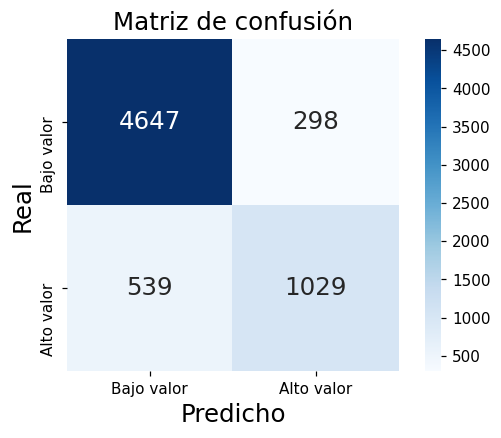

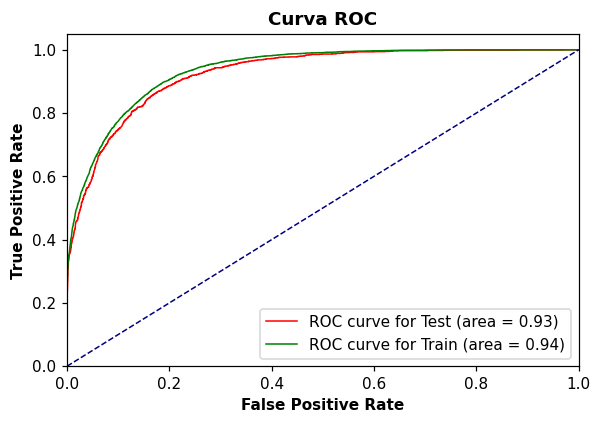

In [15]:
print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf_2.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf_2.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Accuracy sobre train: ", "%0.16f"  % accuracy_score(clf_2.predict(X_train), y_train))
print(classification_report(y_test, y_pred, target_names=["Bajo valor", "Alto valor"]))
print("Los mejores hiperpametros elegidos: ", clf_2.best_params_)
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf_2, X_test, y_test, X_train, y_train)

Nuevamente obtenemos buenas métricas a nivel general y bastante parecidas al primer preprocesamiento. Se redujo la brecha entre el test y train y además mejoro levemente el recall para la clase de altos ingresos. Para finalizar pasamos a testear en el holdout

## Holdouts

Realizamos los testeos requeridos en el holdout. Como el primer preprocesamiento dio levemente mejor la métrica AUC-ROC para el test, utilizamos el primer modelo

In [16]:
from preprocessing import aplicar_preparacion_holdout
X_holdout = aplicar_preparacion_holdout(df_for_prediction, generalizada=False)

Apliquemos el procesado con el que obtuvimos el mejor score AUC-ROC:

In [17]:
X_holdout_numerico = conversion_numerica(X_holdout) 

Aplicando 'conversion_numerica' en las variables categóricas.


Hagamos **.predict()** sobre este holdout para luego agregarlo como nueva columna en este dataset para así exportar el **.csv** con facilidad mediante Pandas. 

In [18]:
y_pred_holdout = clf.predict(X_holdout_numerico)
X_holdout['tiene_alto_valor_adquisitivo'] = y_pred_holdout

In [19]:
name_model = '#6 - Boosting'

if X_holdout.index[0] == 0:
    X_holdout.index += 1 
X_holdout['tiene_alto_valor_adquisitivo'].to_csv('predicciones/' + name_model + '.csv', index=True, index_label = 'id')